In [35]:


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

import shap


## Model
### Objetivos
- Crear modelo regresor base, para luego ir refinandolo
- Revisar el feature Importantes para saber a cuales prestar más atención en un modelo productivo

In [2]:
df = pd.read_csv("../data/HousingData.csv")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[numeric_cols].describe().T

df_viz = df.copy()
for c in numeric_cols:
    if df_viz[c].isna().any():
        df_viz[c] = df_viz[c].fillna(df_viz[c].median())

In [4]:
df_viz

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,11.43,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,11.43,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


## Entrena Regresor simple como base
 De la sección de EDA la variable CHAS es la que tiene menos capacidad predictiva, sin embargo vamos a ver en un modelo
 como esta se comporta


In [36]:
X = df_viz.drop(columns=['MEDV'])
y = df_viz['MEDV'].astype(float)

numeric_cols = list(X.select_dtypes(include=[np.number]).columns)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

regressor = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)   # sin 'squared'
rmse = np.sqrt(mse)                        # <- RMSE
r2 = r2_score(y_test, y_pred)


metrics_df = pd.DataFrame({"metric": ["MAE", "RMSE", "R2"], "value": [mae, rmse, r2]})

metrics_df


,metric,value
0,MAE,3.148737
1,RMSE,4.999938
2,R2,0.659101


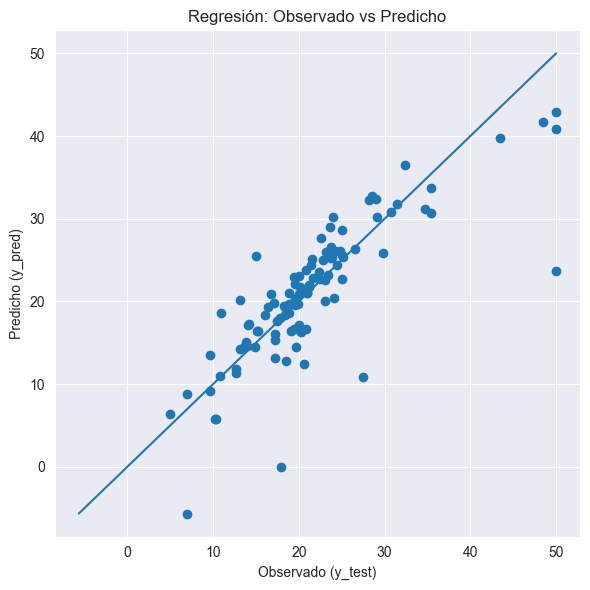

In [37]:
# Scatter plot y_true vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred)
mn = float(min(y_test.min(), y_pred.min()))
mx = float(max(y_test.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Observado (y_test)")
plt.ylabel("Predicho (y_pred)")
plt.title("Regresión: Observado vs Predicho")
plt.tight_layout()


In [38]:
# Extract fitted parts
pre = regressor.named_steps["preprocess"]
lin = regressor.named_steps["model"]

X_train_proc = pre.transform(X_train)
X_test_proc = pre.transform(X_test)

In [39]:
# Feature names
numeric_cols = list(X.select_dtypes(include=[np.number]).columns)
feature_names = numeric_cols

# Use modern SHAP API with an explicit masker
masker = shap.maskers.Independent(X_train_proc)

In [40]:
# LinearExplainer (fast) for linear model
explainer = shap.LinearExplainer(lin, masker=masker)
shap_values = explainer(X_test_proc)  # returns a Explanation
# Convert SHAP values to DataFrame
values = shap_values.values  # numpy array (n_samples, n_features)
shap_df = pd.DataFrame(values, columns=feature_names)
# Mean |SHAP| as feature importance
mean_abs_shap = np.abs(values).mean(axis=0)
fi_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs_shap}).sort_values("mean_abs_shap", ascending=False)


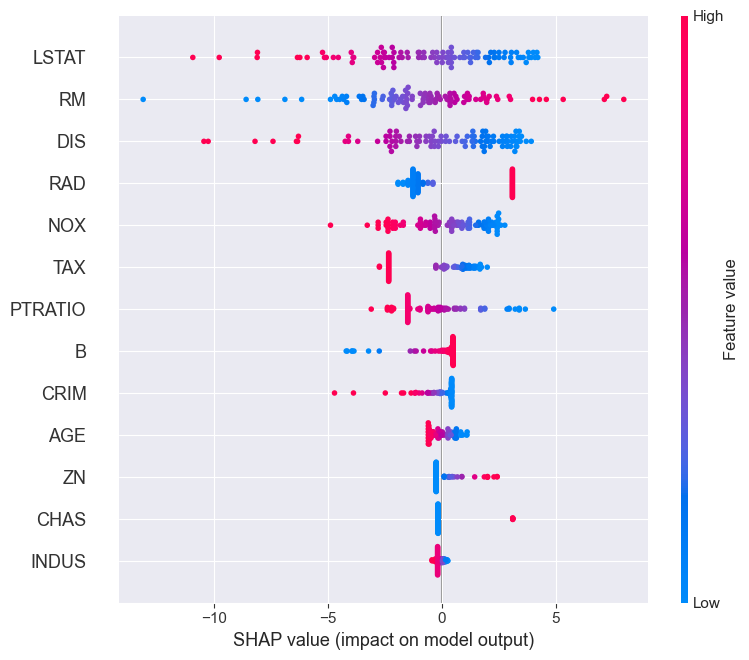

In [41]:
plt.figure(figsize=(8, 3))
shap.summary_plot(values, X_test_proc, feature_names=feature_names, show=False)
plt.tight_layout()

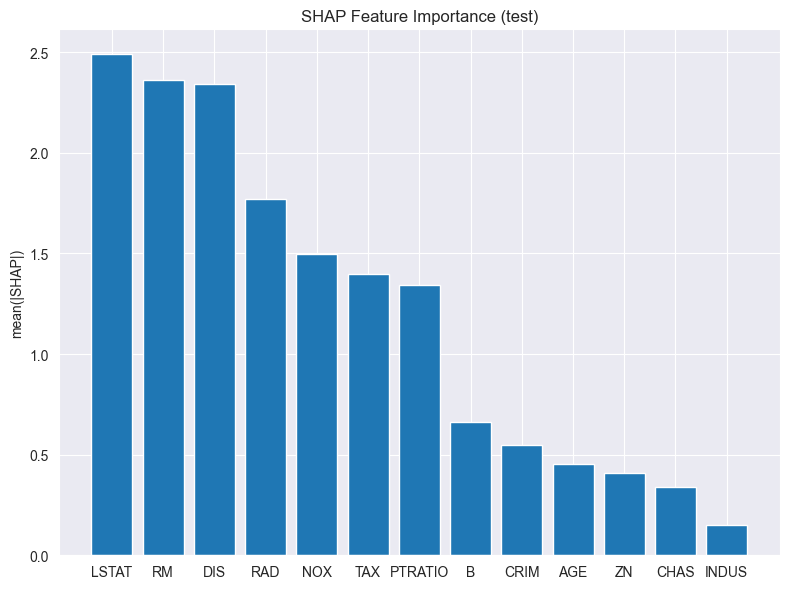

In [42]:
order = np.argsort(mean_abs_shap)[::-1]
plt.figure(figsize=(8, 6))
plt.bar(range(len(order)), mean_abs_shap[order])
plt.xticks(range(len(order)), np.array(feature_names)[order], rotation=0)
plt.ylabel("mean(|SHAP|)")
plt.title("SHAP Feature Importance (test)")
plt.tight_layout()
plt.show()


### Insights de negocio (drivers de precio)

* **LSTAT (↓)**: el factor **más influyente**. Valores altos (rosa) **reducen fuertemente** el precio; bajos (azul) lo **elevan**.

  * *Negocio*: si ofreces crédito/valoración, barrios con LSTAT alto implican **mayor riesgo** de menor valorización; segmenta o ajusta tasas/cupos.
* **RM (↑)**: más habitaciones **suben** el precio de forma consistente.

* **DIS (↑)**: mayor distancia a centros de empleo **eleva** precio en este set (perfil suburbano “deseable”).
*
* **RAD / TAX / NOX (↓)**: alta accesibilidad a autopistas (RAD), **impuestos altos** y **contaminación** bajan el precio.

* **PTRATIO (↓)**: peor ratio alumno/profesor **reduce** precio (calidad educativa).

* **CRIM (↓)**: criminalidad alta empuja precio **a la baja** (efecto puntual pero claro).

### Cómo usar esto en un **modelo productivo**

* **Toma de decisiones**:

  * Define **políticas de pricing** por cluster SHAP (ej., LSTAT alto + NOX alto = descuentos/alertas).
  * Para originación de crédito/seguro, usa umbrales SHAP en **LSTAT/NOX/TAX** para **ajustar riesgo**.
* **Explicabilidad al cliente**:

  * Devuelve un **top-3 de razones SHAP** por inmueble (p. ej., “+RM, –LSTAT, –TAX”) en el reporte de tasación.
* **Monitoreo en producción**:

  * **Drift**: vigila distribución de **LSTAT, RM, NOX, TAX, RAD**; si cambian, el error subirá.
  * **Variables sensibles**: LSTAT es socioeconómica (riesgo de sesgo). Define **política de uso** (p. ej., sólo para explicar, no para negar crédito).
* **Data & features**:

> El precio está **impulsado al alza** por **RM** y **DIS**, y **penalizado** por **LSTAT**, **NOX**, **TAX**, **RAD** y **PTRATIO**. En producción, usa estas señales para **pricing, riesgo y explicación**, y **monitorea drift** especialmente en LSTAT/RM/NOX/TAX.
